In [1]:
import os
import sys

# Add the parent directory to the path to use the modules
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

In [2]:
# Import the custom modules
from src.model import GAN
from src.dataset import CustomDataset

import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from matplotlib import pyplot as plt

In [3]:
def test_with_random_samples(model, device, row, col):
	model.eval()
	generator = model.generator
	with torch.no_grad():
		samples = model.sample(row * col, device)
		generated_images = generator(samples)
		fig, ax = plt.subplots(row, col, figsize=(col, row))
		fig.subplots_adjust(hspace=0, wspace=0)
		fig.suptitle('Random samples from the model')
		for i in range(row):
			for j in range(col):
				image = generated_images[i * col + j]
				min_val = torch.min(image)
				max_val = torch.max(image)
				image = (image - min_val) / (max_val - min_val)
				ax[i, j].imshow(image.permute(1, 2, 0))
				ax[i, j].axis('off')

		plt.show()

In [4]:
def test_with_variations(model, device, row, col, stride=1):
	model.eval()
	generator = model.generator
	with torch.no_grad():
		samples = model.sample(1, device)
		fig, ax = plt.subplots(row, col, figsize=(col, row))
		fig.subplots_adjust(hspace=0, wspace=0)
		fig.suptitle('Variations in the model')
		for i in range(row):
			for j in range(col):
				adjusted_samples = samples
				adjusted_samples[:, model.latent_dim // 2 + stride * (i - row // 2)] += stride * (j - col // 2)
				outputs = generator(adjusted_samples)
				image = outputs[0].permute(1, 2, 0).cpu()
				min_val = torch.min(image)
				max_val = torch.max(image)
				image = (image - min_val) / (max_val - min_val)
				ax[i, j].imshow(image)
				ax[i, j].axis('off')
		plt.show()

In [5]:
def test_with_dataset(model, device, test_loader):
	model.eval()
	generator = model.generator
	discriminator = model.discriminator
	fig, ax = plt.subplots(1, 2, figsize=(10, 5))
	fig.subplots_adjust(hspace=0, wspace=0)
	with torch.no_grad():
		for i, data in enumerate(test_loader):
			data = data.to(device)
			samples = model.sample(1, device)
			generated_images = generator(samples)
			pred_fake = discriminator(generated_images)
			pred_real = discriminator(data)
			ax[0].set_title('Real image\nDiscriminator prediction: {:.4f}'.format(pred_real[0][0].item()))
			ax[0].imshow(data[0].permute(1, 2, 0).cpu())
			ax[0].axis('off')
			ax[1].set_title('Generated image\nDiscriminator prediction: {:.4f}'.format(pred_fake[0][0].item()))
			ax[1].imshow(generated_images[0].permute(1, 2, 0).cpu())
			ax[1].axis('off')
			plt.show()
			break

In [6]:
def test(model, device, test_loader):
	average_generator_loss = 0
	average_discriminator_loss = 0
	model.eval()
	generator = model.generator
	discriminator = model.discriminator
	with torch.no_grad():
		for i, data in enumerate(test_loader):
			data = data.to(device)
			samples = model.sample(data.shape[0], device)
			generated_images = generator(samples)
			pred_fake = discriminator(generated_images)
			pred_real = discriminator(data)
			average_generator_loss += generator.loss_function(pred_fake)
			average_discriminator_loss += discriminator.loss_function(pred_fake, pred_real)
	average_generator_loss /= len(test_loader.dataset)
	average_discriminator_loss /= len(test_loader.dataset)
	print('Average generator loss: {:.4f}'.format(average_generator_loss))
	print('Average discriminator loss: {:.4f}'.format(average_discriminator_loss))

In [26]:
test_transform = transforms.Compose([
	transforms.Resize((64, 64)),
	transforms.ToTensor(),
])
test_data = CustomDataset(
	root='../../data/CelebA/',
	split='test',
	transform=test_transform
)
test_loader = DataLoader(
	dataset=test_data,
	batch_size=128,
	shuffle=True,
	drop_last=False
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using {} device".format(device))
model = GAN().to(device)
model.load_state_dict(torch.load('../../src/model/GAN/CelebA_64_square.pth', map_location=device))

Using cpu device


<All keys matched successfully>

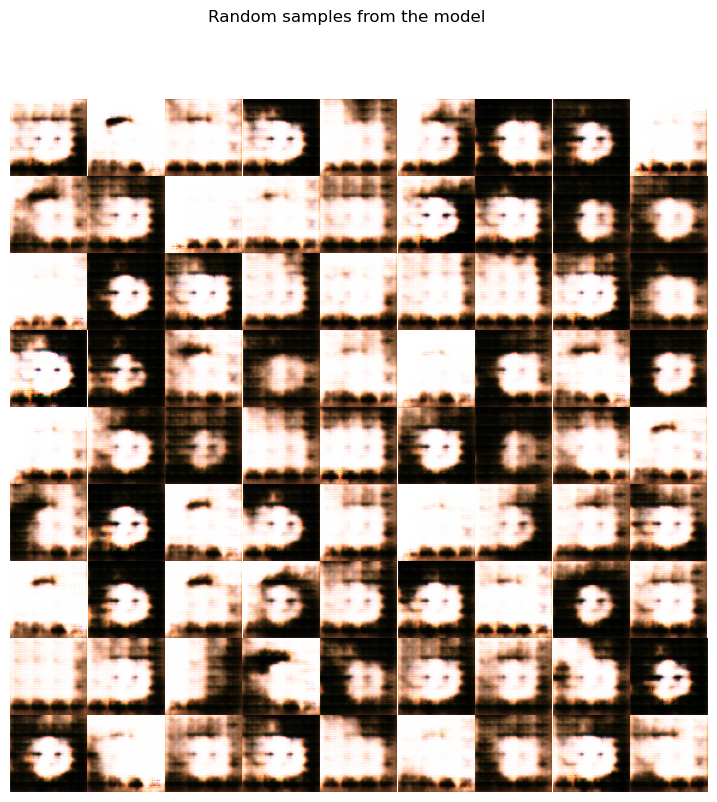

In [27]:
test_with_random_samples(model, device, 9, 9)

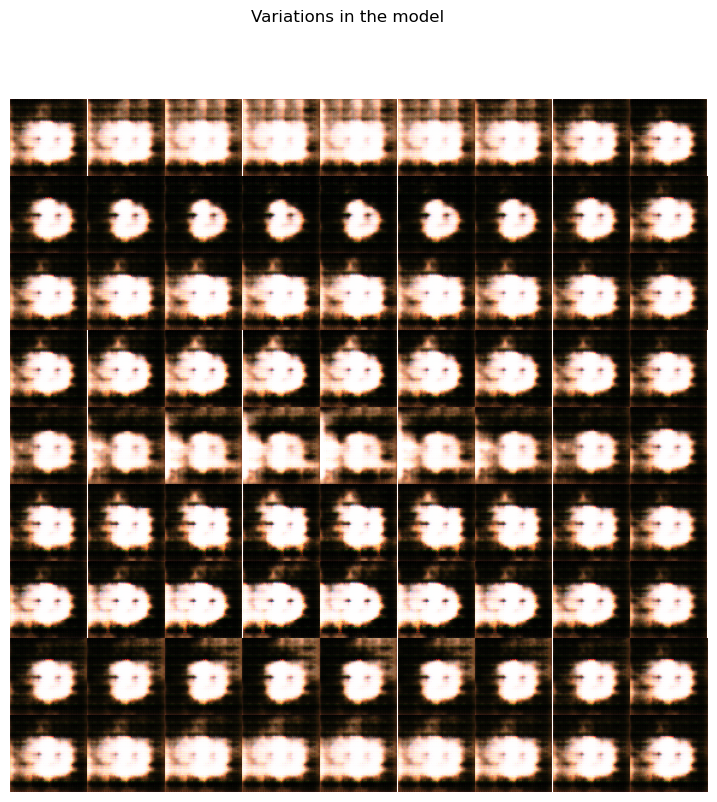

In [28]:
test_with_variations(model, device, 9, 9)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


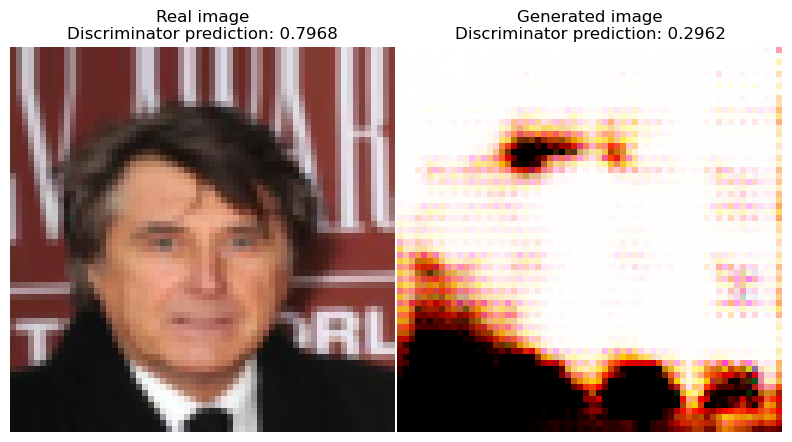

In [29]:
test_with_dataset(model, device, test_loader)

In [49]:
test(model, device, test_loader)

AttributeError: 'Generator' object has no attribute 'loss_function'